# Analysis: tropical cyclone trends over future decades

## Dependency and downloading pre-processed results

First ensure all dependencies are present.

In [ ]:
!pip install git+https://github.com/google-research/swirl-dynamics.git@main
!pip install cartopy

Make imports.

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from etils import epath
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
import pandas as pd
import tqdm.auto as tqdm
import warnings

filesys = epath.backend.gfile_backend
sns.set_style("white")
plt.rcParams.update({'font.size': 12})
warnings.filterwarnings("ignore")

We provide pre-processed cyclone track from the GenFocal outputs, detected by the [TempestExtremes](https://climate.ucdavis.edu/tempestextremes.php) library, in the North Atlantic Ocean (NAO) region (see section G.3.1 in [paper](https://arxiv.org/abs/2412.08079) for criteria). The results can be downladed (using [gsutil](https://cloud.google.com/storage/docs/gsutil_install)) from our Google Cloud Storage bucket.

In [ ]:
DOWNLOAD_TO_PATH = "tc_results/" # @param {"type":"string"}


In [ ]:
!mkdir {DOWNLOAD_TO_PATH}

In [ ]:
!gsutil -m -q cp -R gs://genfocal/results/cyclones {DOWNLOAD_TO_PATH}

We define some parameters, including the geospatial range for the analysis, the resolution (spatial range within which statstics will be aggregated), and a category threshold for the counts.

In [ ]:
LON_RANGE = [270, 330]  #@param
LAT_RANGE = [5, 45]  #@param
PLOT_RESOLUTION = 2.5  #@param
THRESHOLD = "storm" # @param ["depression","storm","category 1","category 2","category 3"]

## Processing and plotting functions

Next, we define some utility functions.

In [ ]:
#@title Track loading
def load_tracks(group):
  exp = f"{DOWNLOAD_TO_PATH}/{group}/**.csv"
  files = filesys.glob(exp)
  files = sorted(
      files, key=lambda x: int(x.split("/")[-1].split("_")[-1][:-4])
  )  # sort by member idx

  dfs = []
  for f in tqdm.tqdm(files):
    df = pd.read_csv(f)
    df = df.iloc[:, 1:]
    dfs.append(df)

  return dfs

In [ ]:
#@title Track processing functions

def filter_tracks(df, ah_wind_thres):
  """Filter tracks based on wind speed."""
  mask = df["ah_wind"] > ah_wind_thres
  return df[mask]


def compute_frequency(dfs, resolution=1.0):
  """Creates a histogram for TC occurrences."""
  lat_min, lat_max = LAT_RANGE
  lon_min, lon_max = LON_RANGE
  lat_bins = np.arange(lat_min, lat_max + resolution, resolution)
  lon_bins = np.arange(lon_min, lon_max + resolution, resolution)

  hist = []
  for df in dfs:
    hist_data, *_ = np.histogram2d(
        df['lon'].to_list(), df['lat'].to_list(),
        bins=[lon_bins, lat_bins],
        range=[[lon_min, lon_max], [lat_min, lat_max]]
    )
    hist.append(hist_data)
  hist_data = np.stack(hist, axis=0)

  return hist_data


def bin_winds(dfs, resolution=1.0):
  """Intensity embodied by the median pressure-derived wind speed."""
  lat_min, lat_max = LAT_RANGE
  lon_min, lon_max = LON_RANGE
  lat_bins = np.arange(lat_min, lat_max + resolution, resolution)
  lon_bins = np.arange(lon_min, lon_max + resolution, resolution)

  winds = np.empty((len(lon_bins) - 1, len(lat_bins) - 1), dtype=object)
  for i in range(len(lon_bins) - 1):
    for j in range(len(lat_bins) - 1):
      winds[i, j] = []

  for df in dfs:
    lon_indices = np.digitize(df['lon'].to_numpy(), lon_bins) - 1
    lat_indices = np.digitize(df['lat'].to_numpy(), lat_bins) - 1
    ah_wind = df['ah_wind'].to_numpy()

    for lon_i, lat_j, ah_w in zip(lon_indices, lat_indices, ah_wind):
      if lon_i < len(lon_bins) - 1 and lat_j < len(lat_bins) - 1:
        winds[lon_i, lat_j].append(ah_w)

  return winds

In [21]:
#@title Plotting functions
def plot_map(data, ax, left_labels=True, bot_labels=True, **kwargs):
  """Creates a geospatial imshow plot."""
  im = ax.imshow(
      np.rot90(data),
      extent=[LON_RANGE[0] - 180, LON_RANGE[1] - 180, LAT_RANGE[0], LAT_RANGE[1]],
      transform=ccrs.PlateCarree(central_longitude=180), **kwargs
  )
  ax.set_aspect("equal")
  ax.set_xlim([LON_RANGE[0] - 180, LON_RANGE[1] - 180])
  ax.set_ylim([LAT_RANGE[0], LAT_RANGE[1]])
  ax.coastlines(resolution="50m", linewidth=0.3, color="black")
  ax.add_feature(cfeature.OCEAN, color="white")
  ax.add_feature(cfeature.LAND, color="lightgray")
  gl = ax.gridlines(
      draw_labels=True, linewidth=0.5, color='gray',
      alpha=0.5, linestyle='--',
  )
  gl.top_labels = False
  gl.right_labels = False
  gl.left_labels = left_labels
  gl.bottom_labels = bot_labels
  gl.xlabel_style = {'size': 12}
  gl.ylabel_style = {'size': 12}
  return im


def add_cbar(im, fig, spec, vpos=0.03, **kwargs):
  """Adds a colorbar to a plot."""
  cbar_ax = fig.add_axes(
      [
          spec.get_position(fig).x0 + 0.005,
          spec.get_position(fig).y0 + vpos,  # Move up slightly
          spec.get_position(fig).width * 0.13,
          spec.get_position(fig).height * 0.85  # Reduce height
      ],
  )
  cbar = fig.colorbar(im, cax=cbar_ax, orientation="vertical", **kwargs)
  cbar.ax.tick_params(axis="both", length=2, labelsize=12)

In [ ]:
#@title Local statistics

median = lambda x: np.median(np.array(x)) if x else 0.0
average = lambda x: np.mean(np.array(x)) if x else 0.0

def percent(p):
  """Computes a specific percentile given a list of samples."""
  return lambda x: np.percentile(np.array(x), p) if x else 0.0

std = lambda x: np.std(np.array(x)) if x else 0.0

def p_value(x, y, method, **kwargs):
  """Computes a p-value for y not equal x."""
  if not x or not y or len(x) < 10 or len(y) < 10:
    return 1.0

  if method == "ttest_ind":
    return stats.ttest_ind(
        y, x, equal_var=False, alternative="two-sided", **kwargs
    ).pvalue
  elif method == "mannwhitneyu":
    return stats.mannwhitneyu(
        y, x, alternative="two-sided", **kwargs
    ).pvalue
  else:
    raise ValueError(f"Unknown method: {method}")

def significance_mask(alpha, method="ttest_ind", **kwargs):
  """Mask out everything except where y != x in a statistically significant way."""
  def _mask(x, y):
    return p_value(x, y, method=method, **kwargs) <= alpha
  return _mask

## Analyze TC trends

To analyze TC trends, we load up the detection results from the decades we wish to study.

In [ ]:
tracks_2010s = load_tracks("nao_tracks_aso2010s")
tracks_2050s = load_tracks("nao_tracks_aso2050s")

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

The results consist of detailed TC track information from 800 GenFocal ensemble members, including:

*   (longitude, latitude) coordinates for track centers
*   time stamps of the occurrence
*   sea level pressure, wind speed and Saffir-Simpson category (computed on the TC centers)



In [24]:
tracks_2010s[0]

,track_id,year,month,day,hour,i,j,lon,lat,slp,wind,zs,ah_wind,saffir_simpson
0,0,2010,8,1,0,105,11,286.25,7.75,100737.90,2.270444,-21.356820,6.323706,Tropical Depression
1,0,2010,8,1,6,102,24,285.50,11.00,100916.70,13.265540,-31.802260,3.022556,Tropical Depression
2,0,2010,8,1,18,102,5,285.50,6.25,100793.50,4.517134,171.425400,5.423597,Tropical Depression
3,0,2010,8,2,0,105,11,286.25,7.75,100726.30,2.869220,-21.356820,6.502553,Tropical Depression
4,0,2010,8,2,6,102,24,285.50,11.00,100754.20,13.971330,-31.802260,6.067554,Tropical Depression
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13118,336,2019,10,30,18,223,179,315.75,49.75,100364.30,17.098170,0.175383,11.188538,Tropical Depression
13119,336,2019,10,31,0,227,179,316.75,49.75,100109.40,18.682110,0.083905,13.901913,Tropical Depression
13120,336,2019,10,31,6,238,179,319.50,49.75,100320.10,15.142080,-0.191127,11.683515,Tropical Depression
13121,336,2019,10,31,12,247,177,321.75,49.25,99886.05,15.395260,-0.191127,16.056853,Tropical Depression


We aggregate detections, i.e. binning within a small local neighborhood (specified by `PLOT_RESOLUTION`) and over all ensemble members, for the detected TCs. Subsequently, we compute statistics (raw count, median and high percentiles) within aggregation groups. The same procedure is applied to detections from both the 2010s and the 2050s, which allows for a direct comparison of the differences.

In [22]:
# Category wind speed thresholds
_WIND_SPEED_LIMIT = {
    "depression": 0.0,
    "storm": 17.0,
    "category 1": 32.0,
    "category 2": 42.0,
    "category 3": 49.0,
}


tracks_2010s_filtered = [filter_tracks(df, _WIND_SPEED_LIMIT[THRESHOLD]) for df in tracks_2010s]
tracks_2050s_filtered = [filter_tracks(df, _WIND_SPEED_LIMIT[THRESHOLD]) for df in tracks_2050s]

sig_mask_50vs10 = np.vectorize(significance_mask(0.05, method="mannwhitneyu"))(
    bin_winds(tracks_2010s_filtered, resolution=PLOT_RESOLUTION),
    bin_winds(tracks_2050s_filtered, resolution=PLOT_RESOLUTION),
)

winds2010s_median = np.vectorize(median)(
    bin_winds(tracks_2010s, resolution=PLOT_RESOLUTION)
)
winds2050s_median = np.vectorize(median)(
    bin_winds(tracks_2050s, resolution=PLOT_RESOLUTION)
)

winds2010s_p90 = np.vectorize(percent(90))(
    bin_winds(tracks_2010s, resolution=PLOT_RESOLUTION)
)
winds2050s_p90 = np.vectorize(percent(90))(
    bin_winds(tracks_2050s, resolution=PLOT_RESOLUTION)
)

We plot the TC trend in terms of change in the computed statistics, applying a mask based on a two-tailed Mann-Whitney U test. This produces Figure 5 in the GenFocal paper.

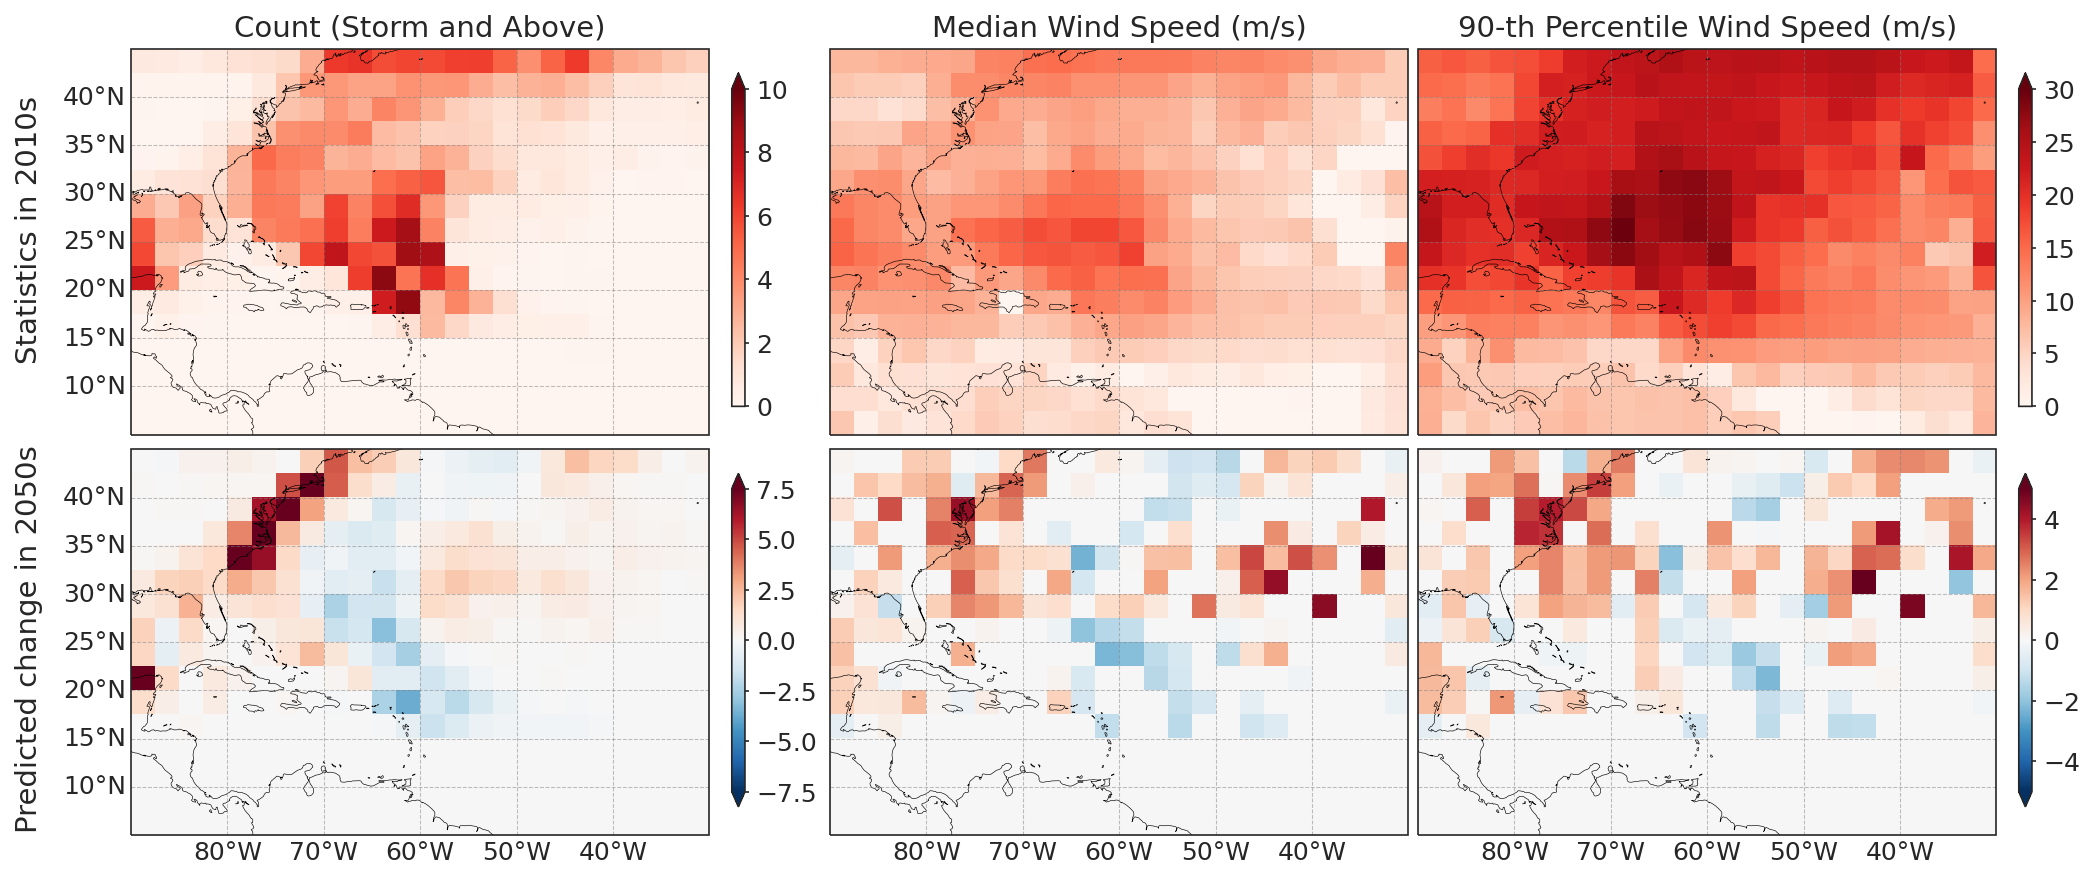

In [23]:
fig = plt.figure(figsize=(17, 7), dpi=75)
gs = mpl.gridspec.GridSpec(
    2, 5, wspace=0.025, hspace=0.021,
    width_ratios=[1, 0.175, 1, 1, 0.175],
)

# plot 2010 storm counts
ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180))
hist2010s = compute_frequency(tracks_2010s_filtered, resolution=PLOT_RESOLUTION)
im = plot_map(
    np.mean(hist2010s, axis=0), ax,
    cmap="Reds", vmin=0, vmax=10., bot_labels=False
)

ax.set_title("Count (Storm and Above)", fontsize=14)
add_cbar(im, fig, gs[0, 1], extend="max")

# plot 2010 mean intensity
ax = fig.add_subplot(gs[0, 2], projection=ccrs.PlateCarree(central_longitude=180))
im = plot_map(
    winds2010s_median, ax,
    cmap="Reds", vmin=0, vmax=30., bot_labels=False, left_labels=False
)
ax.set_title("Median Wind Speed (m/s)", fontsize=14)

# plot 2010 p90 intensity
ax = fig.add_subplot(gs[0, 3], projection=ccrs.PlateCarree(central_longitude=180))
im = plot_map(
    winds2010s_p90, ax,
    cmap="Reds", vmin=0, vmax=30., bot_labels=False, left_labels=False
)
ax.set_title("90-th Percentile Wind Speed (m/s)", fontsize=14)
add_cbar(im, fig, gs[0, 4], extend="max")

# plot 2050 count change
ax = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree(central_longitude=180))
hist2050s = compute_frequency(tracks_2050s_filtered, resolution=PLOT_RESOLUTION)
hist2050s_diff = hist2050s - hist2010s
im = plot_map(
    np.mean(hist2050s_diff, axis=0), ax,
    cmap="RdBu_r", vmin=-7.5, vmax=7.5,
)

add_cbar(im, fig, gs[1, 1], extend="both")

# plot 2050 median intensity change
ax = fig.add_subplot(gs[1, 2], projection=ccrs.PlateCarree(central_longitude=180))
im = plot_map(
    (winds2050s_median - winds2010s_median) * sig_mask_50vs10,
    ax, cmap="RdBu_r", vmin=-5., vmax=5., left_labels=False
)


# plot 2050 p90 intensity change
ax = fig.add_subplot(gs[1, 3], projection=ccrs.PlateCarree(central_longitude=180))
im = plot_map(
    (winds2050s_p90 - winds2010s_p90) * sig_mask_50vs10,
    ax, cmap="RdBu_r", vmin=-5., vmax=5., left_labels=False
)

add_cbar(im, fig, gs[1, 4], extend="both")

fig.text(0.085, 0.705, "Statistics in 2010s", va='center', ha='center', rotation='vertical', fontsize=14)
fig.text(0.085, 0.315, "Predicted change in 2050s", va='center', ha='center', rotation='vertical', fontsize=14)

plt.show()